In [1]:
import os
import sys
import numpy as np
import pandas as pd
%matplotlib inline
from pandas.plotting import scatter_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l1,l2
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.models import load_model
sys.path.insert(0, os.path.join(os.path.expanduser("~"), 'Code/genomic_cnn/'))
from utils.utils import retrieve_data

/home/pau/Code/BioDL/BioDL/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
xh_tr, xh_tst, yh_tr, yh_tst = retrieve_data("height", 10000)
xb_tr, xb_tst, yb_tr, yb_tst = retrieve_data("BHMD",10000)

In [16]:
def Train(x_train,y_train,model,k=150,v=0):
    from keras.callbacks import EarlyStopping, ReduceLROnPlateau
    reduce_lr = ReduceLROnPlateau(factor=0.2, verbose=0, patience=2, min_lr=1e-5)
    early_stopping = EarlyStopping(patience=4, verbose=0)
    callbacks=[early_stopping]
    model.fit(x_train, y_train, callbacks=callbacks, epochs=k, validation_split=0.2, verbose=v)
    return model

In [4]:
def lin_models(nb_snps,lasso=True):
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.regularizers import l1, l2
    a = 0.01
    m = Sequential()
    if lasso:
        m.add(Dense(1,input_dim=nb_snps,kernel_regularizer=l1(a)))
    else:
        m.add(Dense(1,input_dim=nb_snps, kernel_regularizer=l2(a)))
    m.compile(loss='mse', optimizer='adam')
    return m

In [5]:
from utils.utils import convert_to_individual_alleles
from evolve.train import compile_model_mlp
from scipy.stats import pearsonr as r
g={'optimizer': 'adagrad', 'activation': 'elu', 'nb_neurons': 64, 
   'weight_decay': 0.01, 'nb_layers': 2, 'dropout': 0.03}

Z-score feature importance and hidden representations

In [6]:
def zImp(model):
    nf = model.input_shape[1]
    x = np.eye(nf)
    y = model.predict(x).ravel()
    y = (y - y.mean())/y.std()
    y = np.abs(y)
    y = y / y.sum()
    return y


def getH1(model,x):
    m = Model(model.layers[0].input,model.layers[0].output)
    return m.predict(x)

In [7]:
lasso = lin_models(lasso=True,nb_snps=xb_tr.shape[1])
ridge = lin_models(lasso=False,nb_snps=xb_tr.shape[1])
mlp2=compile_model_mlp(g, xb_tr.shape[1])

Architecture:64,elu,adagrad,2,0.03%,0.01%


In [8]:
lasso_h=Train(xh_tr,yh_tr,lasso,v=1)
ridge_h=Train(xh_tr,yh_tr,ridge,v=1)
mlp2_h=Train(xh_tr,yh_tr,mlp2,v=1)

Train on 64000 samples, validate on 16000 samples
Epoch 1/150
64000/64000 [==============================] - 5s 71us/step - loss: 32.2482 - val_loss: 29.7815
Epoch 2/150
64000/64000 [==============================] - 4s 70us/step - loss: 29.1871 - val_loss: 33.8269
Epoch 3/150
64000/64000 [==============================] - 4s 63us/step - loss: 28.6545 - val_loss: 31.0485
Epoch 4/150
64000/64000 [==============================] - 4s 55us/step - loss: 28.3917 - val_loss: 30.5442
Epoch 5/150
64000/64000 [==============================] - 4s 62us/step - loss: 28.4498 - val_loss: 32.7218
Train on 64000 samples, validate on 16000 samples
Epoch 1/150
64000/64000 [==============================] - 4s 66us/step - loss: 30.2437 - val_loss: 26.7174
Epoch 2/150
64000/64000 [==============================] - 4s 69us/step - loss: 25.5887 - val_loss: 26.4861
Epoch 3/150
64000/64000 [==============================] - 5s 71us/step - loss: 24.9566 - val_loss: 28.9811
Epoch 4/150
64000/64000 [===========

In [10]:
import matplotlib
import matplotlib.pyplot as plt
imp = zImp(mlp2_h)
wl = zImp(lasso_h)
wr = zImp(ridge_h)
m = np.asarray([wl.ravel()*100,wr.ravel()*100,imp.ravel()*100])
m = m.transpose()
df = pd.DataFrame(m, columns=['lasso', 'ridge', 'mlp2'])
#axes = scatter_matrix(df, alpha=0.5,figsize=(10, 10), diagonal='kde')
#corr = df.corr().as_matrix()

#plt.suptitle('Varible importance of different models: GWAS 10k')
#plt.savefig('imp_10k.png') 

In [11]:
def scatter_matrix_all(frame, alpha=0.5, figsize=None, grid=False, diagonal='hist', marker='.', density_kwds=None, hist_kwds=None, range_padding=0.05, **kwds):

    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from matplotlib.artist import setp
    import pandas.core.common as com
    from pandas.compat import range, lrange, lmap, map, zip
    import statsmodels.api as sm
    from statsmodels.nonparametric.smoothers_lowess import lowess
    
    df = frame
    num_cols = frame._get_numeric_data().columns.values
    n = df.columns.size
    fig, axes = plt.subplots(nrows=n, ncols=n, figsize=figsize, squeeze=False)

    # no gaps between subplots
    fig.subplots_adjust(wspace=0, hspace=0)

    mask = com.notnull(df)
    marker = _get_marker_compat(marker)

    hist_kwds = hist_kwds or {}
    density_kwds = density_kwds or {}

    # workaround because `c='b'` is hardcoded in matplotlibs scatter method
    kwds.setdefault('c', plt.rcParams['patch.facecolor'])

    boundaries_list = []
    for a in df.columns:
        if a in num_cols:
            values = df[a].values[mask[a].values]
        else:
            values = df[a].value_counts()
        rmin_, rmax_ = np.min(values), np.max(values)
        rdelta_ext = (rmax_ - rmin_) * range_padding / 2.
        boundaries_list.append((rmin_ - rdelta_ext, rmax_+ rdelta_ext))

    for i, a in zip(lrange(n), df.columns):
        for j, b in zip(lrange(n), df.columns):
            ax = axes[i, j]
            if i == j:
                if a in num_cols:    # numerical variable
                    values = df[a].values[mask[a].values]
                    # Deal with the diagonal by drawing a histogram there.
                    if diagonal == 'hist':
                        ax.hist(values, **hist_kwds)
                    elif diagonal == 'name':
                       # import pdb
                        #pdb.set_trace()
                        ax.text(0.5, 0.5,df.columns[i], horizontalalignment='center', color='black',
                                weight='bold', fontsize=20, rotation=45, verticalalignment='center', 
                                transform=ax.transAxes)
                        
                    elif diagonal in ('kde', 'density'):
                        from scipy.stats import gaussian_kde
                        y = values
                        gkde = gaussian_kde(y)
                        ind = np.linspace(y.min(), y.max(), 1000)
                        ax.plot(ind, gkde.evaluate(ind), **density_kwds)
                    ax.set_xlim(boundaries_list[i])
                else:                # categorical variable
                    values = df[a].value_counts()
                    ax.bar(list(range(df[a].nunique())), values)
            else:
                common = (mask[a] & mask[b]).values
                # two numerical variables
                if a in num_cols and b in num_cols:
                    if i > j:
                        ax.scatter(df[b][common], df[a][common], marker=marker, alpha=alpha, **kwds)
                        # The following 2 lines add the lowess smoothing
                        X_plot = np.linspace(0, 1, 100)
                        results = sm.OLS(df[a][common], sm.add_constant(df[b][common])).fit()
                        ax.plot(X_plot, X_plot*results.params[1] + results.params[0], 'red')
                        # ax.plot(ys[:,0], ys[:,1], 'red')
                        pearR = df[[a, b]].corr()
                        ax.text(0.25, 0.75, 'r = %.4f' % (pearR.iloc[0][1]),horizontalalignment='center',
                                fontsize=15, color='black', verticalalignment='center', transform=ax.transAxes)
                    else:
                        pearR = df[[a, b]].corr()
                        ax.text(df[b].min(), df[a].min(), 'r = %.4f' % (pearR.iloc[0][1]))
                    ax.set_xlim(boundaries_list[j])
                    ax.set_ylim(boundaries_list[i])
                # two categorical variables
                elif a not in num_cols and b not in num_cols:
                    if i > j:
                        from statsmodels.graphics import mosaicplot
                        mosaicplot.mosaic(df, [b, a], ax, labelizer=lambda k:'')
                # one numerical variable and one categorical variable
                else:
                    if i > j:
                        tol = pd.DataFrame(df[[a, b]])
                        if a in num_cols:
                            label = [ k for k, v in tol.groupby(b) ]
                            values = [ v[a].tolist() for k, v in tol.groupby(b) ]
                            ax.boxplot(values, labels=label)
                        else:
                            label = [ k for k, v in tol.groupby(a) ]
                            values = [ v[b].tolist() for k, v in tol.groupby(a) ]
                            ax.boxplot(values, labels=label, vert=False)

            ax.set_xlabel('')
            ax.set_ylabel('')

            _label_axis(ax, kind='x', label=b, position='bottom', rotate=True)
            _label_axis(ax, kind='y', label=a, position='left')

            if j!= 0:
                ax.yaxis.set_visible(False)
            if i != n-1:
                ax.xaxis.set_visible(False)

    for ax in axes.flat:
        setp(ax.get_xticklabels(), fontsize=8)
        setp(ax.get_yticklabels(), fontsize=8)
    return fig
    

def _label_axis(ax, kind='x', label='', position='top', ticks=True, rotate=False):
    from matplotlib.artist import setp
    if kind == 'x':
        ax.set_xlabel(label, visible=True)
        ax.xaxis.set_visible(True)
        ax.xaxis.set_ticks_position(position)
        ax.xaxis.set_label_position(position)
        if rotate:
            setp(ax.get_xticklabels(), rotation=90)
    elif kind == 'y':
        ax.yaxis.set_visible(True)
        ax.set_ylabel(label, visible=True)
        #ax.set_ylabel(a)
        ax.yaxis.set_ticks_position(position)
        ax.yaxis.set_label_position(position)
    return


def _get_marker_compat(marker):
    import matplotlib.lines as mlines
    import matplotlib as mpl
    if mpl.__version__ < '1.1.0' and marker == '.':
        return 'o'
    if marker not in mlines.lineMarkers:
        return 'o'
    return marker

/home/pau/Code/BioDL/BioDL/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


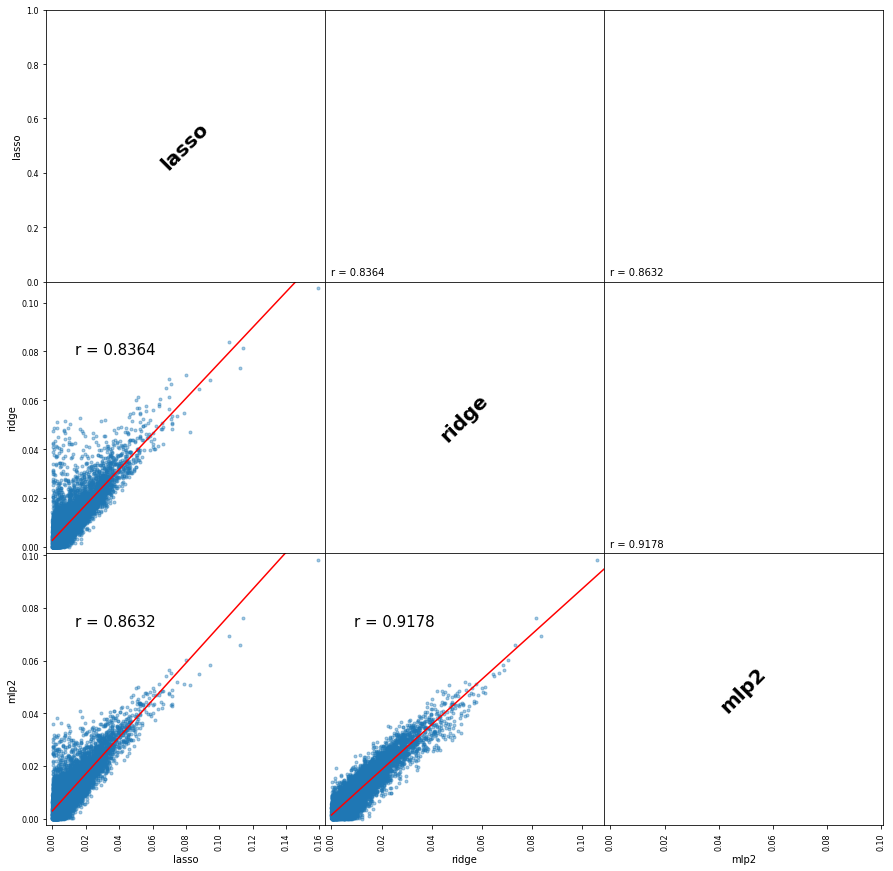

In [12]:
fig = scatter_matrix_all(df, alpha=0.4, figsize=(15,15), diagonal="name")

BHMD

In [13]:
lasso_b=Train(xb_tr,yb_tr,lasso,v=2)
ridge_b=Train(xb_tr,yb_tr,ridge,v=2)
mlp2_b=Train(xb_tr,yb_tr,mlp2,v=2)

Train on 57223 samples, validate on 14306 samples
Epoch 1/150
 - 4s - loss: 4.6106 - val_loss: 1.6290
Epoch 2/150
 - 4s - loss: 0.7199 - val_loss: 0.1760
Epoch 3/150
 - 4s - loss: 0.0868 - val_loss: 0.0624
Epoch 4/150
 - 4s - loss: 0.0793 - val_loss: 0.0766
Epoch 5/150
 - 4s - loss: 0.0837 - val_loss: 0.1181
Epoch 6/150
 - 4s - loss: 0.0955 - val_loss: 0.0785
Epoch 7/150
 - 4s - loss: 0.0940 - val_loss: 0.1078
Train on 57223 samples, validate on 14306 samples
Epoch 1/150
 - 4s - loss: 4.5621 - val_loss: 2.6251
Epoch 2/150
 - 4s - loss: 0.7938 - val_loss: 0.4294
Epoch 3/150
 - 4s - loss: 0.2789 - val_loss: 0.2676
Epoch 4/150
 - 4s - loss: 0.1526 - val_loss: 0.1187
Epoch 5/150
 - 4s - loss: 0.1326 - val_loss: 0.1714
Epoch 6/150
 - 4s - loss: 0.1055 - val_loss: 0.0864
Epoch 7/150
 - 4s - loss: 0.1173 - val_loss: 0.2716
Epoch 8/150
 - 4s - loss: 0.0966 - val_loss: 0.1019
Epoch 9/150
 - 4s - loss: 0.0985 - val_loss: 0.1316
Epoch 10/150
 - 3s - loss: 0.0986 - val_loss: 0.1781
Train on 57223 

Epoch 62/150
 - 15s - loss: 0.4000 - mean_absolute_error: 0.1116 - val_loss: 0.3889 - val_mean_absolute_error: 0.0858
Epoch 63/150
 - 15s - loss: 0.3950 - mean_absolute_error: 0.1113 - val_loss: 0.4033 - val_mean_absolute_error: 0.1545
Epoch 64/150
 - 15s - loss: 0.3900 - mean_absolute_error: 0.1106 - val_loss: 0.3791 - val_mean_absolute_error: 0.0846
Epoch 65/150
 - 15s - loss: 0.3851 - mean_absolute_error: 0.1100 - val_loss: 0.3771 - val_mean_absolute_error: 0.0912
Epoch 66/150
 - 15s - loss: 0.3807 - mean_absolute_error: 0.1102 - val_loss: 0.3890 - val_mean_absolute_error: 0.1459
Epoch 67/150
 - 15s - loss: 0.3761 - mean_absolute_error: 0.1100 - val_loss: 0.3654 - val_mean_absolute_error: 0.0821
Epoch 68/150
 - 15s - loss: 0.3713 - mean_absolute_error: 0.1091 - val_loss: 0.3762 - val_mean_absolute_error: 0.1331
Epoch 69/150
 - 15s - loss: 0.3671 - mean_absolute_error: 0.1089 - val_loss: 0.3590 - val_mean_absolute_error: 0.0890
Epoch 70/150
 - 15s - loss: 0.3625 - mean_absolute_error

Epoch 132/150
 - 15s - loss: 0.2026 - mean_absolute_error: 0.0905 - val_loss: 0.2017 - val_mean_absolute_error: 0.0923
Epoch 133/150
 - 15s - loss: 0.2010 - mean_absolute_error: 0.0901 - val_loss: 0.2025 - val_mean_absolute_error: 0.1018
Epoch 134/150
 - 15s - loss: 0.1995 - mean_absolute_error: 0.0897 - val_loss: 0.2007 - val_mean_absolute_error: 0.1003
Epoch 135/150
 - 15s - loss: 0.1981 - mean_absolute_error: 0.0898 - val_loss: 0.2031 - val_mean_absolute_error: 0.1151
Epoch 136/150
 - 15s - loss: 0.1966 - mean_absolute_error: 0.0896 - val_loss: 0.1976 - val_mean_absolute_error: 0.0939
Epoch 137/150
 - 15s - loss: 0.1952 - mean_absolute_error: 0.0893 - val_loss: 0.1943 - val_mean_absolute_error: 0.0908
Epoch 138/150
 - 15s - loss: 0.1938 - mean_absolute_error: 0.0894 - val_loss: 0.1935 - val_mean_absolute_error: 0.0888
Epoch 139/150
 - 15s - loss: 0.1924 - mean_absolute_error: 0.0891 - val_loss: 0.1905 - val_mean_absolute_error: 0.0830
Epoch 140/150
 - 15s - loss: 0.1909 - mean_absol

In [17]:
mlp2_b=Train(xb_tr,yb_tr,mlp2_b,v=2,k=1000)

Train on 57223 samples, validate on 14306 samples
Epoch 1/1000
 - 15s - loss: 0.1299 - mean_absolute_error: 0.0813 - val_loss: 0.1298 - val_mean_absolute_error: 0.0812
Epoch 2/1000
 - 15s - loss: 0.1293 - mean_absolute_error: 0.0815 - val_loss: 0.1333 - val_mean_absolute_error: 0.1007
Epoch 3/1000
 - 15s - loss: 0.1287 - mean_absolute_error: 0.0815 - val_loss: 0.1286 - val_mean_absolute_error: 0.0813
Epoch 4/1000
 - 15s - loss: 0.1280 - mean_absolute_error: 0.0811 - val_loss: 0.1282 - val_mean_absolute_error: 0.0817
Epoch 5/1000
 - 15s - loss: 0.1275 - mean_absolute_error: 0.0815 - val_loss: 0.1274 - val_mean_absolute_error: 0.0815
Epoch 6/1000
 - 15s - loss: 0.1268 - mean_absolute_error: 0.0811 - val_loss: 0.1268 - val_mean_absolute_error: 0.0818
Epoch 7/1000
 - 15s - loss: 0.1262 - mean_absolute_error: 0.0811 - val_loss: 0.1269 - val_mean_absolute_error: 0.0859
Epoch 8/1000
 - 15s - loss: 0.1255 - mean_absolute_error: 0.0807 - val_loss: 0.1266 - val_mean_absolute_error: 0.0842
Epoch 

Epoch 70/1000
 - 15s - loss: 0.0969 - mean_absolute_error: 0.0782 - val_loss: 0.0978 - val_mean_absolute_error: 0.0821
Epoch 71/1000
 - 15s - loss: 0.0965 - mean_absolute_error: 0.0779 - val_loss: 0.0975 - val_mean_absolute_error: 0.0812
Epoch 72/1000
 - 15s - loss: 0.0962 - mean_absolute_error: 0.0779 - val_loss: 0.0970 - val_mean_absolute_error: 0.0810
Epoch 73/1000
 - 15s - loss: 0.0958 - mean_absolute_error: 0.0776 - val_loss: 0.0980 - val_mean_absolute_error: 0.0849
Epoch 74/1000
 - 15s - loss: 0.0956 - mean_absolute_error: 0.0782 - val_loss: 0.0964 - val_mean_absolute_error: 0.0813
Epoch 75/1000
 - 15s - loss: 0.0951 - mean_absolute_error: 0.0776 - val_loss: 0.0991 - val_mean_absolute_error: 0.0910
Epoch 76/1000
 - 15s - loss: 0.0948 - mean_absolute_error: 0.0777 - val_loss: 0.0958 - val_mean_absolute_error: 0.0819
Epoch 77/1000
 - 15s - loss: 0.0946 - mean_absolute_error: 0.0781 - val_loss: 0.0955 - val_mean_absolute_error: 0.0817
Epoch 78/1000
 - 15s - loss: 0.0942 - mean_absol

Epoch 139/1000
 - 15s - loss: 0.0782 - mean_absolute_error: 0.0767 - val_loss: 0.0796 - val_mean_absolute_error: 0.0815
Epoch 140/1000
 - 15s - loss: 0.0779 - mean_absolute_error: 0.0766 - val_loss: 0.0837 - val_mean_absolute_error: 0.0962
Epoch 141/1000
 - 15s - loss: 0.0777 - mean_absolute_error: 0.0764 - val_loss: 0.0790 - val_mean_absolute_error: 0.0809
Epoch 142/1000
 - 15s - loss: 0.0775 - mean_absolute_error: 0.0766 - val_loss: 0.0788 - val_mean_absolute_error: 0.0808
Epoch 143/1000
 - 15s - loss: 0.0773 - mean_absolute_error: 0.0766 - val_loss: 0.0785 - val_mean_absolute_error: 0.0809
Epoch 144/1000
 - 15s - loss: 0.0771 - mean_absolute_error: 0.0764 - val_loss: 0.0795 - val_mean_absolute_error: 0.0843
Epoch 145/1000
 - 15s - loss: 0.0769 - mean_absolute_error: 0.0764 - val_loss: 0.0811 - val_mean_absolute_error: 0.0904
Epoch 146/1000
 - 15s - loss: 0.0767 - mean_absolute_error: 0.0761 - val_loss: 0.0779 - val_mean_absolute_error: 0.0811
Epoch 147/1000
 - 15s - loss: 0.0765 - m

In [20]:
def scatter_matrix_all(frame, alpha=0.5, figsize=None, grid=False, diagonal='hist', marker='.', density_kwds=None, hist_kwds=None, range_padding=0.05, **kwds):

    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from matplotlib.artist import setp
    import pandas.core.common as com
    from pandas.compat import range, lrange, lmap, map, zip
    import statsmodels.api as sm
    from statsmodels.nonparametric.smoothers_lowess import lowess
    
    df = frame
    num_cols = frame._get_numeric_data().columns.values
    n = df.columns.size
    fig, axes = plt.subplots(nrows=n, ncols=n, figsize=figsize, squeeze=False)

    # no gaps between subplots
    fig.subplots_adjust(wspace=0, hspace=0)

    mask = com.notnull(df)
    marker = _get_marker_compat(marker)

    hist_kwds = hist_kwds or {}
    density_kwds = density_kwds or {}

    # workaround because `c='b'` is hardcoded in matplotlibs scatter method
    kwds.setdefault('c', plt.rcParams['patch.facecolor'])

    boundaries_list = []
    for a in df.columns:
        if a in num_cols:
            values = df[a].values[mask[a].values]
        else:
            values = df[a].value_counts()
        rmin_, rmax_ = np.min(values), np.max(values)
        rdelta_ext = (rmax_ - rmin_) * range_padding / 2.
        boundaries_list.append((rmin_ - rdelta_ext, rmax_+ rdelta_ext))

    for i, a in zip(lrange(n), df.columns):
        for j, b in zip(lrange(n), df.columns):
            ax = axes[i, j]
            if i == j:
                if a in num_cols:    # numerical variable
                    values = df[a].values[mask[a].values]
                    # Deal with the diagonal by drawing a histogram there.
                    if diagonal == 'hist':
                        ax.hist(values, **hist_kwds)
                    elif diagonal == 'name':
                       # import pdb
                        #pdb.set_trace()
                        ax.text(0.5, 0.5,df.columns[i], horizontalalignment='center', color='black',
                                weight='bold', fontsize=20, rotation=45, verticalalignment='center', 
                                transform=ax.transAxes)
                        
                    elif diagonal in ('kde', 'density'):
                        from scipy.stats import gaussian_kde
                        y = values
                        gkde = gaussian_kde(y)
                        ind = np.linspace(y.min(), y.max(), 1000)
                        ax.plot(ind, gkde.evaluate(ind), **density_kwds)
                    ax.set_xlim(boundaries_list[i])
                else:                # categorical variable
                    values = df[a].value_counts()
                    ax.bar(list(range(df[a].nunique())), values)
            else:
                common = (mask[a] & mask[b]).values
                # two numerical variables
                if a in num_cols and b in num_cols:
                    if i > j:
                        ax.scatter(df[b][common], df[a][common], marker=marker, alpha=alpha, **kwds)
                        # The following 2 lines add the lowess smoothing
                        X_plot = np.linspace(0, 1, 100)
                        results = sm.OLS(df[a][common], sm.add_constant(df[b][common])).fit()
                        ax.plot(X_plot, X_plot*results.params[1] + results.params[0], 'red')
                        # ax.plot(ys[:,0], ys[:,1], 'red')
                        pearR = df[[a, b]].corr()
                        ax.text(0.25, 0.75, 'r = %.4f' % (pearR.iloc[0][1]),horizontalalignment='center',
                                fontsize=15, color='black', verticalalignment='center', transform=ax.transAxes)
                    else:
                        pearR = df[[a, b]].corr()
                        ax.text(df[b].min(), df[a].min(), 'r = %.4f' % (pearR.iloc[0][1]))
                    ax.set_xlim(boundaries_list[j])
                    ax.set_ylim(boundaries_list[i])
                # two categorical variables
                elif a not in num_cols and b not in num_cols:
                    if i > j:
                        from statsmodels.graphics import mosaicplot
                        mosaicplot.mosaic(df, [b, a], ax, labelizer=lambda k:'')
                # one numerical variable and one categorical variable
                else:
                    if i > j:
                        tol = pd.DataFrame(df[[a, b]])
                        if a in num_cols:
                            label = [ k for k, v in tol.groupby(b) ]
                            values = [ v[a].tolist() for k, v in tol.groupby(b) ]
                            ax.boxplot(values, labels=label)
                        else:
                            label = [ k for k, v in tol.groupby(a) ]
                            values = [ v[b].tolist() for k, v in tol.groupby(a) ]
                            ax.boxplot(values, labels=label, vert=False)

            ax.set_xlabel('')
            ax.set_ylabel('')

            _label_axis(ax, kind='x', label=b, position='bottom', rotate=True)
            _label_axis(ax, kind='y', label=a, position='left')

            if j!= 0:
                ax.yaxis.set_visible(False)
            if i != n-1:
                ax.xaxis.set_visible(False)

    for ax in axes.flat:
        setp(ax.get_xticklabels(), fontsize=8)
        setp(ax.get_yticklabels(), fontsize=8)
    return fig
    

def _label_axis(ax, kind='x', label='', position='top', ticks=True, rotate=False):
    from matplotlib.artist import setp
    if kind == 'x':
        ax.set_xlabel(label, visible=True)
        ax.xaxis.set_visible(True)
        ax.xaxis.set_ticks_position(position)
        ax.xaxis.set_label_position(position)
        if rotate:
            setp(ax.get_xticklabels(), rotation=90)
    elif kind == 'y':
        ax.yaxis.set_visible(True)
        ax.set_ylabel(label, visible=True)
        #ax.set_ylabel(a)
        ax.yaxis.set_ticks_position(position)
        ax.yaxis.set_label_position(position)
    return


def _get_marker_compat(marker):
    import matplotlib.lines as mlines
    import matplotlib as mpl
    if mpl.__version__ < '1.1.0' and marker == '.':
        return 'o'
    if marker not in mlines.lineMarkers:
        return 'o'
    return marker

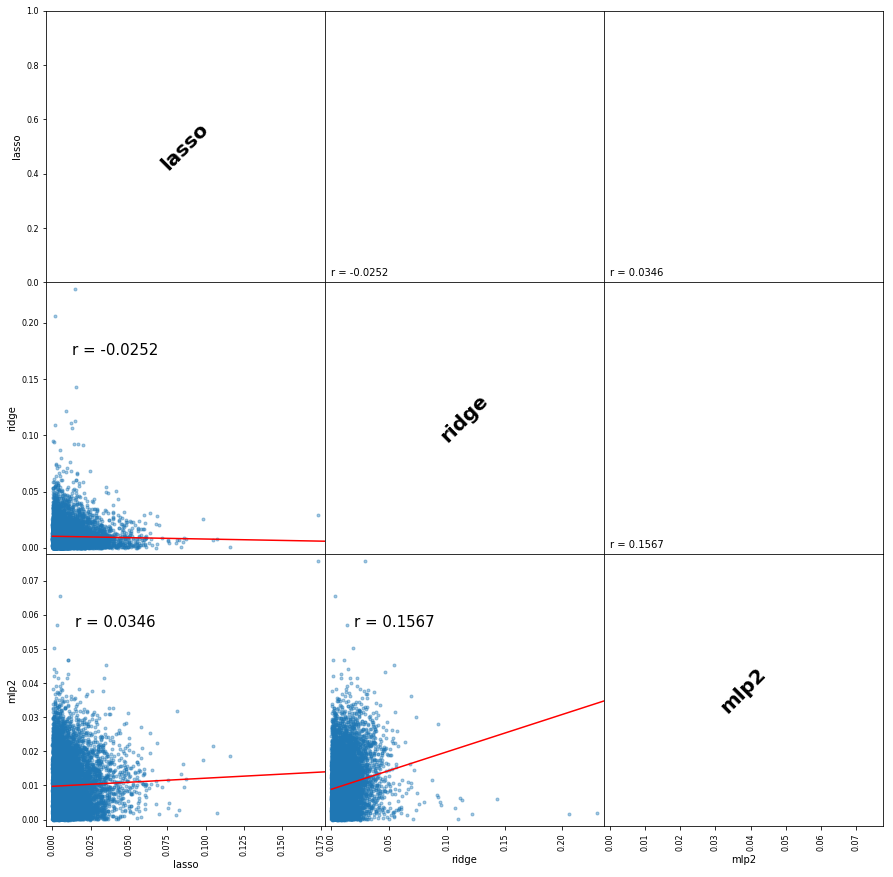

In [21]:
imp_b = zImp(mlp2_b)
wl_b = zImp(lasso_b)
wr_b = zImp(ridge_b)
m_b = np.asarray([wl_b.ravel()*100,wr_b.ravel()*100,imp_b.ravel()*100])
m_b = m_b.transpose()
df_b = pd.DataFrame(m_b, columns=['lasso', 'ridge', 'mlp2'])
fig = scatter_matrix_all(df_b, alpha=0.4, figsize=(15,15), diagonal="name")